In [1]:
def get_medium():
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import glob
    import sklearn.preprocessing
    %matplotlib inline
    np.set_printoptions(threshold=np.nan)

    files = glob.glob("C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\World Bank\\*.csv")
    i = 0
    start_year = '1971'
    end_year = '2014'
    series = []
    for file in files:
        if file[-14:-4] == 'population':
            df = pd.read_csv(file, index_col = 0)
            series.append(file[52:-4])
        else:
            df = pd.read_csv(file, index_col = 0, skiprows = 4)
            series.append(file[52:-4])
        df.head()
        if i == 0:
            data = df.loc['World',start_year:end_year].reset_index().values
            i = 1
        elif file[-14:-4] == 'population':
            df = df[df['Country Code'].str.match('WLD')]

            data = np.concatenate((data,df[df['Year'].between(int(start_year),int(end_year))].values[:,2].reshape(-1,1)),axis = 1)
        else:
            data = np.concatenate((data,df.loc['World',start_year:end_year].values.reshape(-1,1)),axis = 1)

    data = data[0:,1:]
    ecopd = pd.read_csv("C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\ecological_footprint.csv", index_col = None)
    ecopd = ecopd.iloc[:,2:-2].drop(['Record'], axis = 1)
    data = np.concatenate((data[:,:], ecopd.iloc[10:,-1].values.reshape(-1,1)),axis = 1)
    series.append('ecological footprint')
    fossils = pd.read_csv("C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\global-fossil-fuel-consumption.csv", index_col = 0)
    data = np.concatenate((data[:,:], fossils.loc[start_year:end_year,'Total'].values.reshape(-1,1)),axis = 1)
    series.append('fossil fuels')
    years = list(range(1971,1971+data.shape[0]))
    data = pd.DataFrame(data = data, columns = series, index = years)
    #data.to_csv(path_or_buf = "C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\medium.csv" )
    return data

In [2]:
def get_big():
    df = pd.read_csv("C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\world_data_1.csv")
    df = df.loc[:,:].replace('..', np.NaN)
    start_year = '1971'
    end_year = '2010'
    rows = np.where(np.prod(df.loc[:,start_year:end_year].notna().values, axis = 1))[0]
    df = df.iloc[rows,:]
    pred_steps = 14
    series = df.iloc[:,2].values
    df = df.loc[:,start_year:end_year]
    train = df.iloc[:,:].values.astype(float)
    years = df.loc[:,:].columns.values
    train = pd.DataFrame(data = train.T, columns = series, index = years)
    data = get_medium()
    years
    return data

In [3]:
import sklearn.preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sklearn.preprocessing
%matplotlib inline
np.set_printoptions(threshold=np.nan)
data = get_medium()
data = data[['food production','gdp','population','ecological footprint','fossil fuels']]
scaler = sklearn.preprocessing.StandardScaler()
train = scaler.fit_transform(data)
train = train.reshape(1,-1,train.shape[1])
trainX = train[:,:30,:]
trainY = train[:,30,:]
#trainY = trainY.reshape(trainY.shape[1], trainY.shape[2])
testX = train[:,42-7:42,:]
testY = train[:,42:44,:]
#testY = testY.reshape(testY.shape[1], testY.shape[2])

In [4]:
import tensorflow as tf
tf.reset_default_graph()
from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate, BatchNormalization, LSTM, Embedding, Flatten
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error, mean_squared_error
train = scaler.fit_transform(data)
data_gen = TimeseriesGenerator(train, train, length=7, batch_size = 1)
print(len(data_gen))

embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(LSTM(20, dropout_U = 0.2, dropout_W = 0.2, input_shape = (7,train.shape[1])))
#model.add(Flatten())
model.add(Dense(trainX.shape[2]))
model.compile(loss = 'mse', optimizer='adam',metrics = ['accuracy'])


C:\tools\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


37


C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(20, input_shape=(7, 5), dropout=0.2, recurrent_dropout=0.2)`


In [5]:
model.fit_generator(data_gen, epochs=1000)
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0,0,:,0], trainPredict[0,:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0,0,:,0], testPredict[0,:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/1000
37/37 [==============================] - 2s 45ms/step - loss: 0.5465 - acc: 0.2162
Epoch 2/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.3079 - acc: 0.2162
Epoch 3/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.1497 - acc: 0.2973
Epoch 4/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0830 - acc: 0.5405
Epoch 5/1000
37/37 [==============================] - 0s 7ms/step - loss: 0.0767 - acc: 0.4865
Epoch 6/1000
37/37 [==============================] - 0s 11ms/step - loss: 0.0532 - acc: 0.5676
Epoch 7/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0514 - acc: 0.4865
Epoch 8/1000
37/37 [==============================] - 0s 11ms/step - loss: 0.0570 - acc: 0.4595
Epoch 9/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0373 - acc: 0.5946
Epoch 10/1000
37/37 [==============================] - 0s 8ms/step - loss: 0.0437 - acc: 0.5135
Epoch 11/1000
37/37 [========================

37/37 [==============================] - 0s 9ms/step - loss: 0.0174 - acc: 0.6757
Epoch 171/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0212 - acc: 0.6486
Epoch 172/1000
37/37 [==============================] - 0s 11ms/step - loss: 0.0197 - acc: 0.6757
Epoch 173/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0200 - acc: 0.6757
Epoch 174/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0075 - acc: 0.7568
Epoch 175/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0177 - acc: 0.6486
Epoch 176/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0119 - acc: 0.7568
Epoch 177/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0184 - acc: 0.5946
Epoch 178/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0067 - acc: 0.7297
Epoch 179/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0094 - acc: 0.6486
Epoch 180/1000
37/37 [==================

37/37 [==============================] - 0s 9ms/step - loss: 0.0111 - acc: 0.6486
Epoch 339/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0134 - acc: 0.7297
Epoch 340/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0129 - acc: 0.6757
Epoch 341/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0156 - acc: 0.7297
Epoch 342/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0090 - acc: 0.7027
Epoch 343/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0127 - acc: 0.7568
Epoch 344/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0120 - acc: 0.6486
Epoch 345/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0085 - acc: 0.7568
Epoch 346/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0099 - acc: 0.7297
Epoch 347/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0146 - acc: 0.6757
Epoch 348/1000
37/37 [===================

37/37 [==============================] - 0s 10ms/step - loss: 0.0077 - acc: 0.7027
Epoch 507/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0071 - acc: 0.7027
Epoch 508/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0121 - acc: 0.7297
Epoch 509/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0119 - acc: 0.7027
Epoch 510/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0101 - acc: 0.7297
Epoch 511/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0082 - acc: 0.7568
Epoch 512/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0110 - acc: 0.7838
Epoch 513/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0088 - acc: 0.7027
Epoch 514/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0055 - acc: 0.7568
Epoch 515/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0089 - acc: 0.8108
Epoch 516/1000
37/37 [================

37/37 [==============================] - 0s 9ms/step - loss: 0.0050 - acc: 0.7568
Epoch 675/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0101 - acc: 0.7568
Epoch 676/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0121 - acc: 0.7297
Epoch 677/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0085 - acc: 0.8108
Epoch 678/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0068 - acc: 0.7297
Epoch 679/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0084 - acc: 0.7568
Epoch 680/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0055 - acc: 0.7838
Epoch 681/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0069 - acc: 0.6757
Epoch 682/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0062 - acc: 0.8108
Epoch 683/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0066 - acc: 0.7297
Epoch 684/1000
37/37 [====================

37/37 [==============================] - 0s 9ms/step - loss: 0.0107 - acc: 0.7568
Epoch 843/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0064 - acc: 0.8108
Epoch 844/1000
37/37 [==============================] - 0s 8ms/step - loss: 0.0096 - acc: 0.8108
Epoch 845/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0079 - acc: 0.8108
Epoch 846/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0076 - acc: 0.8108
Epoch 847/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0078 - acc: 0.7568
Epoch 848/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0059 - acc: 0.7568
Epoch 849/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0101 - acc: 0.7568
Epoch 850/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0073 - acc: 0.7838
Epoch 851/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0062 - acc: 0.8108
Epoch 852/1000
37/37 [====================

37/37 [==============================] - 0s 10ms/step - loss: 0.0051 - acc: 0.8378
Epoch 927/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.0058 - acc: 0.7838
Epoch 928/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0076 - acc: 0.7568
Epoch 929/1000
37/37 [==============================] - 0s 9ms/step - loss: 0.0054 - acc: 0.8108
Epoch 930/1000
37/37 [==============================] - 0s 6ms/step - loss: 0.0043 - acc: 0.7568
Epoch 931/1000
37/37 [==============================] - 0s 6ms/step - loss: 0.0071 - acc: 0.7568
Epoch 932/1000
37/37 [==============================] - 0s 8ms/step - loss: 0.0070 - acc: 0.7838
Epoch 933/1000
37/37 [==============================] - 0s 7ms/step - loss: 0.0079 - acc: 0.7838
Epoch 934/1000
37/37 [==============================] - 0s 7ms/step - loss: 0.0053 - acc: 0.7297
Epoch 935/1000
37/37 [==============================] - 0s 7ms/step - loss: 0.0074 - acc: 0.8378
Epoch 936/1000
37/37 [=====================

ValueError: Error when checking input: expected lstm_1_input to have shape (7, 5) but got array with shape (30, 5)

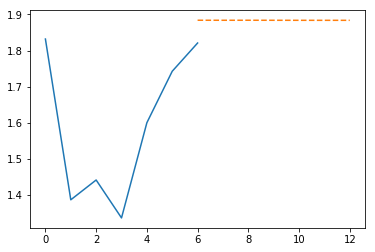

In [6]:
pred_vec = testX

for i in range(15):
    #print(pred_vec)
    pred_vec_new = model.predict(pred_vec)

    pred_vec[:,0,:] = pred_vec_new
    pred_vec = np.roll(pred_vec,-1, 1)
    
plt.plot(range(0,pred_vec.shape[1]), testX[0,:,4])
plt.plot(range(6,6+pred_vec.shape[1]), pred_vec[0,:,4],'--')


In [ ]:
pred_vec = testX
pred_vec_new = model.predict(pred_vec)
print(np.mean((pred_vec_new-testY)/testY))